- To solve this kind of problems, I believe Gaussian Processes (scikit-optimize) is well suited algorithm, as it models the objective function that we can define ourselves and optimize (minimize) it. 
- It utilizes balancing of exploration and exploitation -  exploring new areas of the search space and exploiting known good areas. 
- "GP minimize" learns and adapts based on previous results, improving the search over time, making it more time efficient than standart methods
- Because possible combinations looks enormous, I first create a simpler synthetic data for rapid prototyping excercise. 
- In the next notebook, I use original data to optimize using 1000 iterations, which tooks me around 12 hours to run optimization on my old laptop.  

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
from scipy.spatial.distance import cdist
from skopt.space import Integer

In [ ]:
import math 
n = 120
k = 10 
math.comb(n, k) / 1000000000 # billions

116068.178638776

# Synthetic data

- Get a smaller portion of b (30 bus stops), as easier to work with, and syntethic a (addresses) that has clear 4 clusters
- We will optimize 4 bus stops out of 30

In [ ]:
a1 = pd.read_csv('synthetic1.csv').drop(columns="Unnamed: 0")
b1 = pd.read_csv('Potentail_Bust_Stops_lat_long_corrected.csv'
                 ).drop(columns="Unnamed: 0"
                 ).sample(n=30, random_state=42).sort_values(by='latitude') # randomly samle 30 out of bus stops

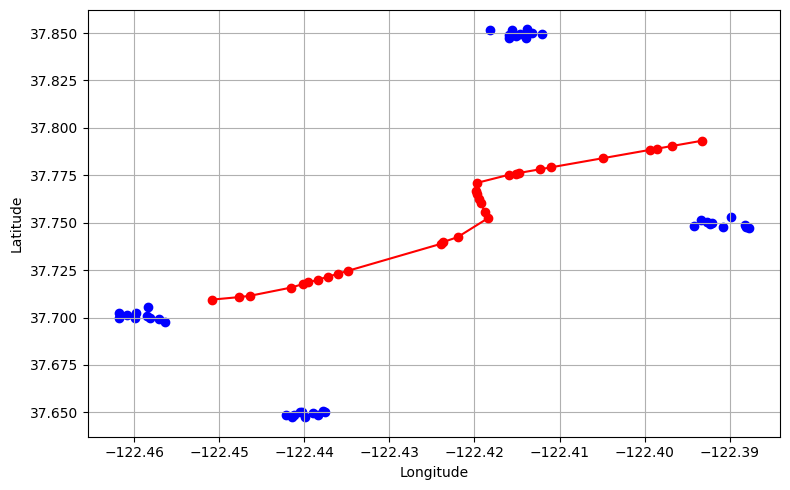

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b1['longitude'], b1['latitude'], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of smaller amount of employees
axs.scatter(a1['longitude'], a1['latitude'], c='blue', marker='o')
plt.tight_layout() 

In [116]:
b1 = b1[['latitude', 'longitude']].to_numpy()
a1 = a1[['latitude', 'longitude']].to_numpy()

- Here, we are going to find an optimum of 4 bus stops  out of 30 possible

In [117]:
n_points = len(b1)
subset_size = 4

initial_points = [x for x in range(14, 14+subset_size)]
initial_points 

[14, 15, 16, 17]

- I initialize the initial data 4 bus stops to be far away from the employee adresses to visualize the results of the optimization in a more clear way later.
- Initial 4 points are depicted as X on the map below

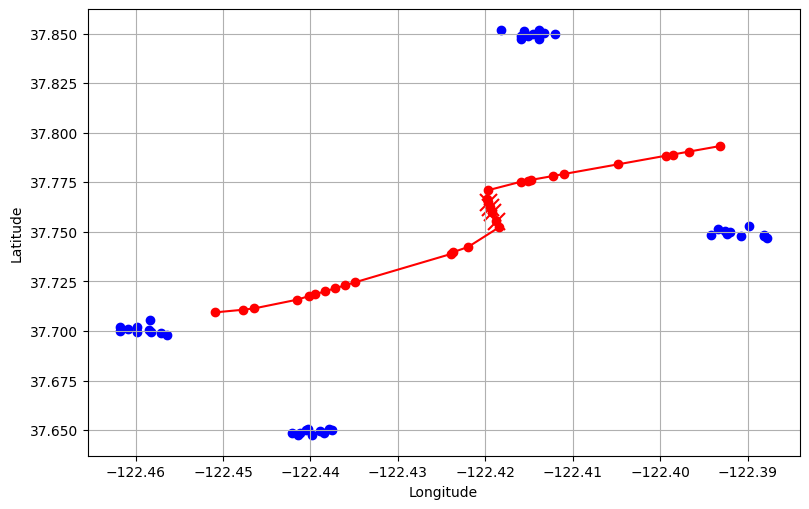

In [118]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 2 - addresses of all employees
axs.scatter(a1[:, 1], a1[:, 0], c='blue', marker='o')
plt.tight_layout() 

# Plot 1 - potential bus stops
axs.plot(b1[:, 1], b1[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 3 - initial bus stops random combinations
axs.scatter(b1[initial_points, 1], b1[initial_points, 0], c='red', marker='x', s=150); 

- Create a search space for the gp_minimization
- These are possible indices (total 30) for the 4 bus stops. 
- I later enforce uniquiness of the combinations in the objective function.  

In [ ]:
space = [Integer(0, n_points-1) for _ in range(subset_size)]
space

[Integer(low=0, high=29, prior='uniform', transform='identity'),
 Integer(low=0, high=29, prior='uniform', transform='identity'),
 Integer(low=0, high=29, prior='uniform', transform='identity'),
 Integer(low=0, high=29, prior='uniform', transform='identity')]

- I define objective function. It aims to select unique bus stops out of the possible bus stops to minimize the total distance employees have to travel to the nearest bus stop.
- Inside the objective function, I use penalty value in the objective function, to penalize combinations which has non-unique points inside. 
- Thus I enforce that points in each combination are unique e.g. [14,15,16,17]

In [ ]:
penalty = 1e10

def objective(indices):
    
    if len(set(indices)) != len(indices): 
        return penalty 
    
    selected_points = b1[np.array(indices, dtype=int)] 
    distances = cdist(a1, selected_points)
    return np.sum(np.min(distances, axis=1))

# Here, I run GP minimization of the objective function

result = gp_minimize( func=objective, 
                      dimensions=space,  # Search space
                      acq_func="EI",     # Expected improvement
                      n_calls=200,       # Number of iterations
                      random_state=42,
                      x0=initial_points, 
                      n_restarts_optimizer=5, 
                      acq_optimizer = 'auto',
                      verbose=True ) 

In [121]:
best_indices = result.x
selected_points = b1[np.array(best_indices, dtype=int)]

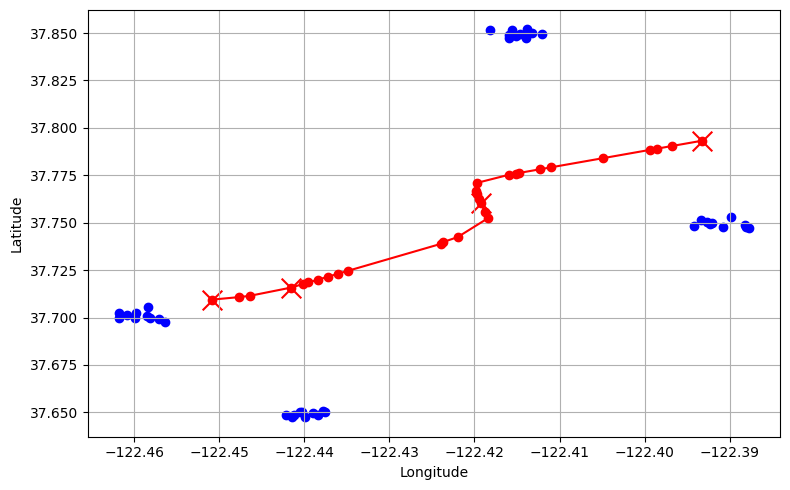

In [122]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b1[:, 1], b1[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a1[:, 1], a1[:, 0], c='blue', marker='o')

# Plot 3 - selected points after optimization
axs.scatter(selected_points[:, 1], selected_points[:, 0], c='red', marker='x', s=200)
plt.tight_layout()

- We can see that the distances have been minimized between each employee and potential bus stops to create a solution above. 
- I only run 200 iterations here, we can run much more as data is small. 
- I run 1000 iterations in the next notebook to optimize on all 119 potential bus stops to find 10 best bus stops, as specified in the assignment task